In [11]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib  # To save the model

# Load the dataset (if not already in memory)
file_path = "datap/processed_clinical_result.csv"
df = pd.read_csv(file_path)

# Define features (X) and target (y)
X = df.drop(columns=["label"])
y = df["label"]

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')


In [12]:
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Train-Test Split Done: {X_train.shape[0]} Train Samples, {X_test.shape[0]} Test Samples")


✅ Train-Test Split Done: 641 Train Samples, 161 Test Samples


In [13]:
# Calculate scale_pos_weight (ratio of majority to minority class)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(f"✅ Calculated scale_pos_weight: {scale_pos_weight:.2f}")


✅ Calculated scale_pos_weight: 2.77


In [14]:
# Define XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05,
    max_depth=6, 
    scale_pos_weight=scale_pos_weight,  # Handles class imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train the model
xgb_model.fit(X_train, y_train)

print("✅ XGBoost Model Trained Successfully!")


✅ XGBoost Model Trained Successfully!


In [15]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Accuracy: {accuracy:.4f}")

# Classification Report
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ XGBoost Accuracy: 0.9752

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       118
           1       0.98      0.93      0.95        43

    accuracy                           0.98       161
   macro avg       0.98      0.96      0.97       161
weighted avg       0.98      0.98      0.97       161


🔍 Confusion Matrix:
[[117   1]
 [  3  40]]


In [16]:
# Save trained XGBoost model
model_path = "models/xgboost_model.pkl"
joblib.dump(xgb_model, model_path)

print(f"✅ Model Saved at: {model_path}")


✅ Model Saved at: models/xgboost_model.pkl


In [17]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Define k for k-fold cross-validation
k = 5  # Change as needed

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='accuracy')

# Print results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


Cross-validation accuracy scores: [0.95652174 0.95652174 0.9625     0.93125    0.96875   ]
Mean accuracy: 0.9551
Standard deviation: 0.0128


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance from the trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame
feature_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

# Sort by importance
feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)

# Display top 10 features
print("🔍 Top 10 Most Important Features in XGBoost:")
print(feature_imp_df.head(10))


🔍 Top 10 Most Important Features in XGBoost:
                    Feature  Importance
15    mc_synonymous_variant    0.352396
23             mc_stop_lost    0.119695
20              mc_nonsense    0.111224
22      mc_missense_variant    0.074077
18  mc_splice_donor_variant    0.067524
21        mc_intron_variant    0.053964
0                  position    0.051369
13                   BP_T>G    0.024068
14      Normalized_Position    0.017380
17   mc_5_prime_UTR_variant    0.017097


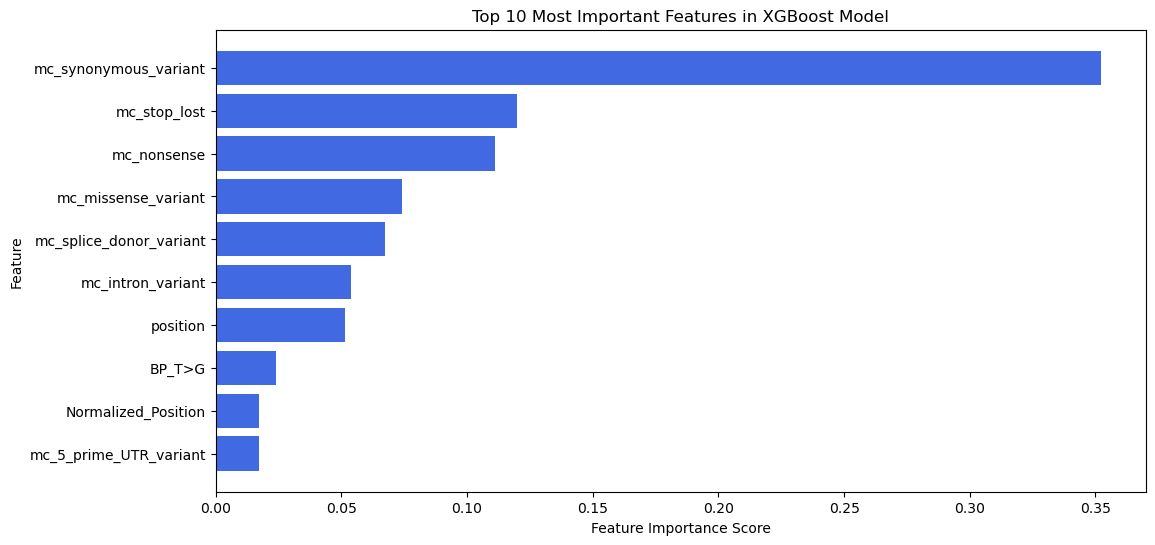

In [19]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_imp_df["Feature"][:10], feature_imp_df["Importance"][:10], color="royalblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features in XGBoost Model")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()
